Program ten ma na celu zwiększenie rozdzielczości obrazu podczas korzystania z biblioteki Tensorflow

Źródło: https://www.tensorflow.org/hub/tutorials/image_enhancing


In [111]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [112]:
  # ścieżka do pliku obrazu
image_path = keras.utils.get_file("original.jpg", "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg") 

In [113]:
# Declaring Constants
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [114]:
def preprocess_image(image_path): # Ładuje obraz ze ścieżki i wstępnie przetworzony, aby przygotować model
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename): # Zapisuje bezskalowane obrazy Tensorowe.
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [115]:
%matplotlib inline
def plot_image(image, title=""): # Rysuje obrazy
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [116]:
hr_image = preprocess_image(image_path)

Saved as original_im.jpg


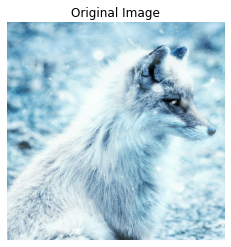

In [117]:
# Rysowanie obrazu o oryginalnej rozdzielczości
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="original_im")

In [118]:
model = hub.load(SAVED_MODEL_PATH)

In [119]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 1.335562


Saved as super_resolution.jpg


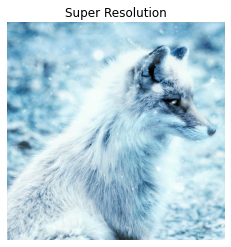

In [120]:
# Wyświetlenie Obrazu W Super Rozdzielczości
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="super_resolution")

In [121]:
# Definiowanie funkcji pomocniczych
def downscale_image(image): # Obniża rozdzielczość obrazów za pomocą downsamplingu bicubic
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [122]:
hr_image = preprocess_image(image_path)

In [123]:
lr_image = downscale_image(tf.squeeze(hr_image))

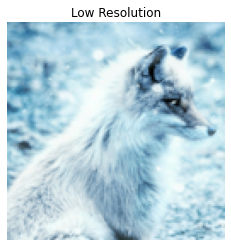

In [124]:
# Wyświetlenie obrazu o niskiej rozdzielczości
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [125]:
model = hub.load(SAVED_MODEL_PATH)

In [126]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 1.091628


PSNR Achieved: 28.029171


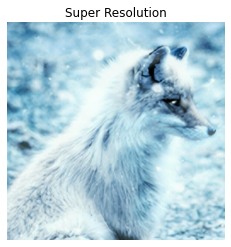

In [127]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Powiększa rozdzielczość obraza małej rozdielności
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: 28.029171


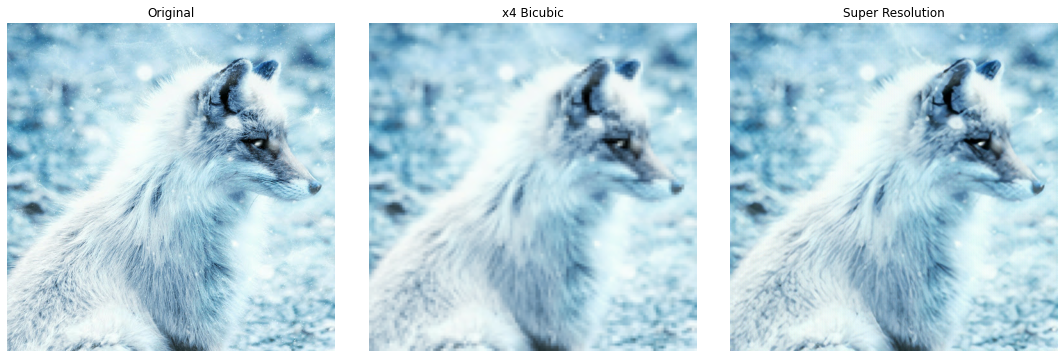

In [128]:
# Wyświetlenie wszystkich obrazów
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)